### Attempt to engineer features for learning

        - Use DT as proxy with FI chart

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn import model_selection as sk
from sklearn import metrics as m
from sklearn import preprocessing as p
from sklearn import svm, linear_model, cluster, ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin

%store -r df 
%store -r x 
%store -r y

%store -r cols
%store -r testsizepercent
%store -r rs

## Functions

In [50]:
def plotUnivariateROC_cond(preds, truth, label_string, auc_del=.6):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''

    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = m.roc_curve(truth, preds)
    
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = m.auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = m.roc_curve(truth, -1 * preds)
        roc_auc = m.auc(fpr, tpr)

    if roc_auc>auc_del:    
        #chooses a random color for plotting
        c = (np.random.rand(), np.random.rand(), np.random.rand())

        #create a plot and set some options
        plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)


        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC')
        plt.legend(loc="lower right")
    
    return roc_auc

    
def plotMI(dat, lab, width = 0.35):
    '''
    Draw a bar chart of the normalized MI between each X and Y
    '''
    X = dat.drop(lab, 1)
    Y = dat[[lab]].values
    cols = X.columns.values
    mis = []

    #Start by getting MI
    for c in cols:
        mis.append(m.normalized_mutual_info_score(Y.ravel(), X[[c]].values.ravel()))

    #Get signs by correlation
    corrs = dat.corr()[lab]
    corrs[corrs.index != lab]
    df = pd.DataFrame(list(zip(mis, cols)), columns = ['MI', 'Lab'])
    df = pd.concat([df, pd.DataFrame(list(corrs), columns = ['corr'])], axis=1).reindex()
    makeBarSigned(df, 'MI', 'Lab', width)
    
def makeBarSigned(df, h, lab,  width):
    '''
    Contains
    '''
    df_s = df.sort_values(by = [h], ascending = False)

    #Get a barplot
    ind = np.arange(df_s.shape[0])
    labs = df_s[[lab]].values.ravel()
    h_pos = (df_s[['corr']].values.ravel() > 0) * df_s.MI
    h_neg = (df_s[['corr']].values.ravel() < 0) * df_s.MI

    fig = plt.figure(facecolor = 'w', figsize = (12, 6))
    ax = plt.subplot(111)
    plt.subplots_adjust(bottom = 0.25)

    rec = ax.bar(ind + width, h_pos, width, color='r', label = 'Positive')
    rec = ax.bar(ind + width, h_neg, width, color='b', label = 'Negative')

    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(labs, rotation = 45, size = 14)

    plt.legend()
    
class CustomScaler(BaseEstimator,TransformerMixin): 
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        self.scaler = p.StandardScaler(copy,with_mean,with_std)
        self.columns = columns

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.iloc[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

## Building New Features
    
We add $x^2$, $x^3$, $e^x$ of each feature with some exceptions

- no new features for `fConc`, `fConc1`, `fSize`
- no exponential for `fDist`, `fAsym`

Yields 30 features 

In [51]:
#Add Features
fe_df = df.copy()
fe_cols = cols[0:10].copy()

In [52]:
for col in cols:
    if (col!='fConc'and col!='fConc1' and col!='fSize' and col!='Class'):  
        fe_df['x2_'+col]=fe_df.apply((lambda row: row[col]**2), axis=1)
        fe_df['x3_'+col]=fe_df.apply((lambda row: row[col]**3), axis=1)
        fe_cols.append('x2_'+col)
        fe_cols.append('x3_'+col)
        
fe_df['AbsConcs']=fe_df.apply((lambda row: (abs(row['fConc'])+abs(row['fConc1']))), axis=1)
fe_cols.append('AbsConcs')
fe_cols.append('Class')
fe_df = fe_df[fe_cols]

In [53]:
#Building Train/Test Splits of New Feature Data

fe_y = fe_df['Class']
fe_x = fe_df.drop('Class', 1)

x_fetr, x_fete, y_fetr, y_fete = sk.train_test_split(fe_x, fe_y, 
                                                     test_size=testsizepercent, 
                                                     stratify=fe_y)

### Analyze New Features 

#### Univariate

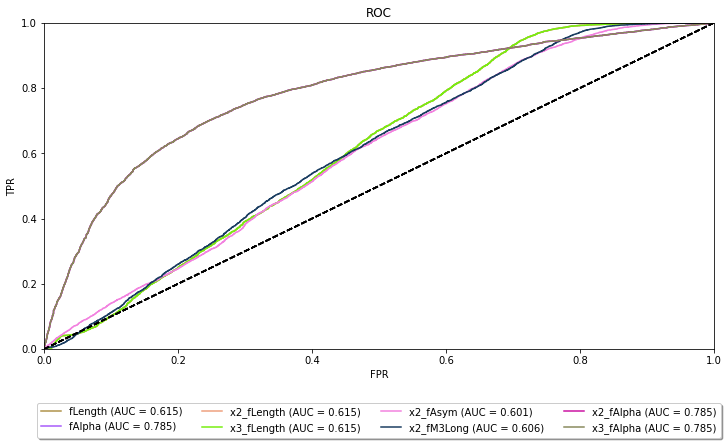

In [54]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC

feature_auc_dict = {}
for col in fe_x.columns:
    feature_auc_dict[col] = plotUnivariateROC_cond(fe_x[col], fe_y, col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

### Mutual Information

In [55]:
#DT for feature importance

dt = DecisionTreeClassifier(criterion = 'entropy')
dt.fit(x_fetr, y_fetr)
feature_mi = dt.feature_importances_
feature_mi_dict = dict(zip(fe_x.columns.values, feature_mi))


Text(0.5, 1.0, 'Mutual Information Between Feature and Class')

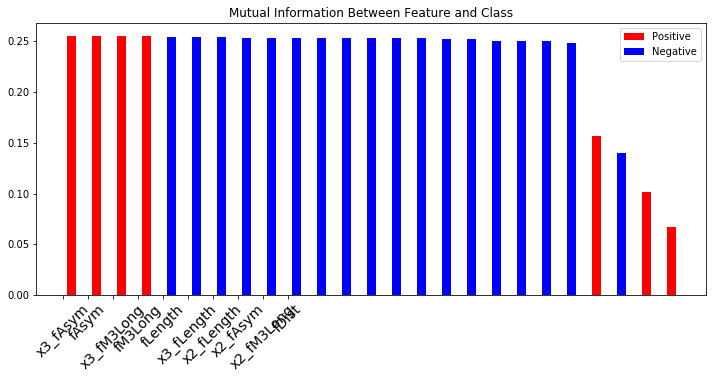

In [56]:
import warnings
warnings.filterwarnings('ignore')

plotMI(fe_df, 'Class')
plt.title('Mutual Information Between Feature and Class')

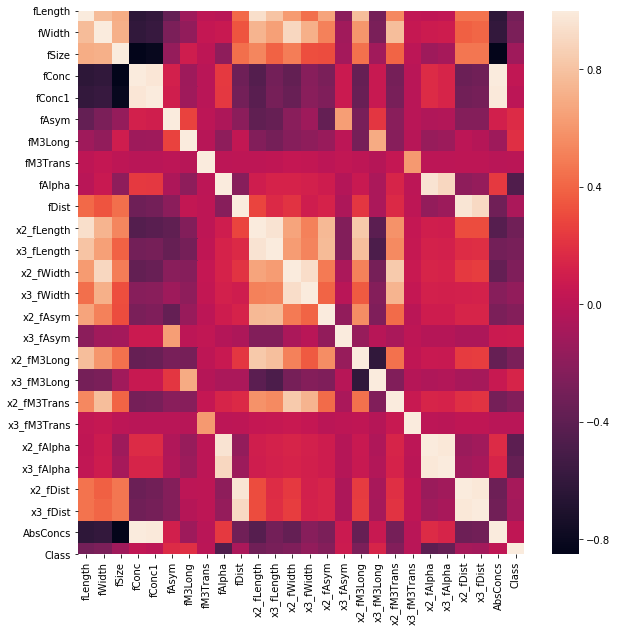

In [57]:
fig, ax = plt.subplots(figsize=(10,10))     
sns.heatmap(fe_df.corr(), annot=False)

## Resampling

- Balancing Class Quantities in Data

In [58]:
df_gamma = df[df['Class']==1]
df_hadron = df[df['Class']==0]

In [59]:
df_hadron_upsampled = resample(df_hadron, 
                                 replace=True,     # sample with replacement
                                 n_samples=12332)    # to match majority

In [60]:
df_gamma

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1
...,...,...,...,...,...,...,...,...,...,...,...
12327,12.8703,11.4444,2.3811,0.7360,0.3805,-15.0946,5.3032,11.6208,21.0120,204.0370,1
12328,26.8595,20.5946,2.8754,0.3438,0.2152,-3.4556,-20.0014,-9.0535,3.9848,205.4980,1
12329,22.0913,10.8949,2.2945,0.5381,0.2919,15.2776,18.2296,7.3975,21.0680,123.2810,1
12330,56.2216,18.7019,2.9297,0.2516,0.1393,96.5758,-41.2969,11.3764,5.9110,197.2090,1


In [61]:
df_hadron_upsampled

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class
18146,182.8099,91.4597,4.1414,0.0442,0.0411,64.6934,-142.9141,-49.8209,67.0593,180.2302,0
12574,84.0407,16.6481,3.0164,0.2396,0.1226,-97.1136,59.2023,-17.7659,24.7881,262.5706,0
14362,66.5488,20.2547,2.9344,0.3426,0.2033,-79.5401,67.0317,-13.7203,18.4979,269.7718,0
15722,27.0181,6.8552,2.4698,0.6169,0.3203,32.3712,16.0717,-4.8840,5.3160,191.2250,0
17064,155.8560,95.4667,3.7478,0.1004,0.0535,-211.8370,100.2090,-85.8418,50.3906,254.7590,0
...,...,...,...,...,...,...,...,...,...,...,...
13479,52.6302,25.7179,3.1599,0.2567,0.1429,-18.9906,-68.0658,-19.6104,18.2750,201.4780,0
14977,29.5713,18.3141,2.6222,0.5585,0.3091,-21.7437,-29.3980,8.8532,23.7230,175.0250,0
15052,45.1659,12.2610,2.9511,0.2925,0.1840,60.0913,55.9376,-5.7269,31.0284,192.5941,0
16768,11.1450,10.3286,2.1558,0.7575,0.4058,11.2841,16.0731,5.2311,51.9644,39.9839,0


In [62]:
up_df = pd.concat([df_gamma, df_hadron_upsampled], ignore_index=True)

In [63]:
up_df['Class'].value_counts()

1    12332
0    12332
Name: Class, dtype: int64

In [64]:
#Building Train/Test Splits of Upsampled Data

up_y = up_df['Class']
up_x = up_df.drop('Class', 1)


x_uptr, x_upte, y_uptr, y_upte = sk.train_test_split(up_x, up_y, 
                                                     test_size=testsizepercent, 
                                                     stratify=up_y)

In [65]:
up_df[up_df['Class']==0]

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class
12332,182.8099,91.4597,4.1414,0.0442,0.0411,64.6934,-142.9141,-49.8209,67.0593,180.2302,0
12333,84.0407,16.6481,3.0164,0.2396,0.1226,-97.1136,59.2023,-17.7659,24.7881,262.5706,0
12334,66.5488,20.2547,2.9344,0.3426,0.2033,-79.5401,67.0317,-13.7203,18.4979,269.7718,0
12335,27.0181,6.8552,2.4698,0.6169,0.3203,32.3712,16.0717,-4.8840,5.3160,191.2250,0
12336,155.8560,95.4667,3.7478,0.1004,0.0535,-211.8370,100.2090,-85.8418,50.3906,254.7590,0
...,...,...,...,...,...,...,...,...,...,...,...
24659,52.6302,25.7179,3.1599,0.2567,0.1429,-18.9906,-68.0658,-19.6104,18.2750,201.4780,0
24660,29.5713,18.3141,2.6222,0.5585,0.3091,-21.7437,-29.3980,8.8532,23.7230,175.0250,0
24661,45.1659,12.2610,2.9511,0.2925,0.1840,60.0913,55.9376,-5.7269,31.0284,192.5941,0
24662,11.1450,10.3286,2.1558,0.7575,0.4058,11.2841,16.0731,5.2311,51.9644,39.9839,0


## Visualize Upsample

- all looks the same

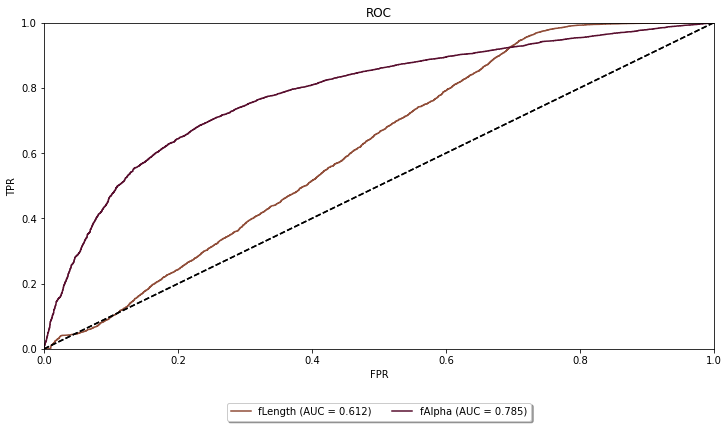

In [67]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC


feature_auc_dict = {}
for col in up_df.drop('Class',1).columns:
    feature_auc_dict[col] = plotUnivariateROC_cond(up_df[col], up_df['Class'], col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

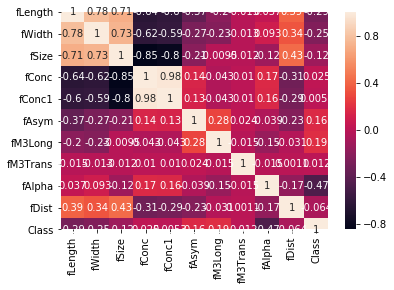

In [68]:
sns.heatmap(up_df.corr(), annot=True)

Text(0.5, 1.0, 'Mutual Information Between Feature and Class - M^F')

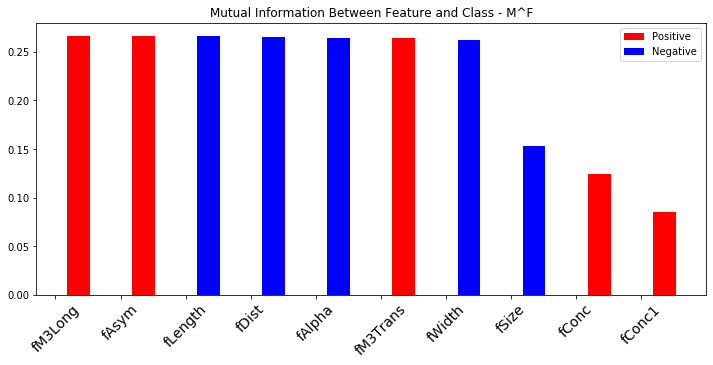

In [69]:
#DT for feature importance

dt_u = DecisionTreeClassifier(criterion = 'entropy')
dt_u.fit(up_df.drop('Class',1),up_df['Class'])
feature_mi = dt_u.feature_importances_
feature_mi_dict = dict(zip(up_df.drop('Class',1).columns.values, feature_mi))

import warnings
warnings.filterwarnings('ignore')

plotMI(up_df, 'Class')
plt.title('Mutual Information Between Feature and Class - M^F')

## Scaling

In [70]:
scale = CustomScaler(columns=fe_cols[0:25])
fedf_sc = scale.fit_transform(fe_df)

fe_ys = fedf_sc['Class']
fe_xs = fedf_sc.drop('Class', 1)

xs_fetr, xs_fete, ys_fetr, ys_fete = sk.train_test_split(fe_xs, fe_ys, 
                                                     test_size=testsizepercent, 
                                                     stratify=fe_ys)

In [71]:
scale = CustomScaler(columns=cols[0:10])
updf_sc = scale.fit_transform(up_df)

up_ys = updf_sc['Class']
up_xs = updf_sc.drop('Class', 1)

xs_uptr, xs_upte, ys_uptr, ys_upte = sk.train_test_split(up_xs, up_ys, 
                                                     test_size=testsizepercent, 
                                                     stratify=up_ys)

## Storing Variables

In [72]:
#Feature Engineering Results

#New Features
%store fe_df
%store fe_x
%store fe_y
%store x_fetr
%store y_fetr
%store x_fete
%store y_fete

#New Features- scaled
%store fedf_sc
%store fe_xs
%store fe_ys
%store xs_fetr
%store ys_fetr
%store xs_fete
%store ys_fete

#Upsampled Data
%store up_df
%store up_x
%store up_y
%store x_uptr
%store y_uptr
%store x_upte
%store y_upte

#Upsampled Data - scaled
%store updf_sc
%store up_xs
%store up_ys
%store xs_uptr
%store ys_uptr
%store xs_upte
%store ys_upte

%store fe_cols

Stored 'fe_df' (DataFrame)
Stored 'fe_x' (DataFrame)
Stored 'fe_y' (Series)
Stored 'x_fetr' (DataFrame)
Stored 'y_fetr' (Series)
Stored 'x_fete' (DataFrame)
Stored 'y_fete' (Series)
Stored 'fedf_sc' (DataFrame)
Stored 'fe_xs' (DataFrame)
Stored 'fe_ys' (Series)
Stored 'xs_fetr' (DataFrame)
Stored 'ys_fetr' (Series)
Stored 'xs_fete' (DataFrame)
Stored 'ys_fete' (Series)
Stored 'up_df' (DataFrame)
Stored 'up_x' (DataFrame)
Stored 'up_y' (Series)
Stored 'x_uptr' (DataFrame)
Stored 'y_uptr' (Series)
Stored 'x_upte' (DataFrame)
Stored 'y_upte' (Series)
Stored 'updf_sc' (DataFrame)
Stored 'up_xs' (DataFrame)
Stored 'up_ys' (Series)
Stored 'xs_uptr' (DataFrame)
Stored 'ys_uptr' (Series)
Stored 'xs_upte' (DataFrame)
Stored 'ys_upte' (Series)
Stored 'fe_cols' (list)
